In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('attraction reviews.csv', low_memory = False)
df = df[[col for col in df.columns if 'photo' not in col]]  # Create a new DataFrame with filtered 
#columns that get rid of all the 'photo' columns




In [2]:
df.columns

Index(['helpfulVotes', 'id', 'lang', 'locationId', 'ownerResponse',
       'ownerResponse/connectionToSubject', 'ownerResponse/id',
       'ownerResponse/lang', 'ownerResponse/publishedDate',
       'ownerResponse/responder', 'ownerResponse/text', 'placeInfo/address',
       'placeInfo/addressObj/city', 'placeInfo/addressObj/country',
       'placeInfo/addressObj/postalcode', 'placeInfo/addressObj/state',
       'placeInfo/addressObj/street1', 'placeInfo/addressObj/street2',
       'placeInfo/latitude', 'placeInfo/locationString', 'placeInfo/longitude',
       'placeInfo/name', 'placeInfo/numberOfReviews', 'placeInfo/rating',
       'placeInfo/ratingHistogram/count1', 'placeInfo/ratingHistogram/count2',
       'placeInfo/ratingHistogram/count3', 'placeInfo/ratingHistogram/count4',
       'placeInfo/ratingHistogram/count5', 'placeInfo/webUrl',
       'placeInfo/website', 'publishedDate', 'publishedPlatform', 'rating',
       'roomTip', 'text', 'title', 'travelDate', 'tripType', 'url', '

Our goal is to cluster the data into groups that have minimal separation to better understand what differentiates restaurants.

In [3]:
df['placeInfo/name']
## The place name we will use as reference

0                                  Wine O'Clock
1                                  Wine O'Clock
2                                  Wine O'Clock
3                                  Wine O'Clock
4                                  Wine O'Clock
                          ...                  
15107    Velitour Elite Tourism Services Greece
15108    Velitour Elite Tourism Services Greece
15109    Velitour Elite Tourism Services Greece
15110    Velitour Elite Tourism Services Greece
15111    Velitour Elite Tourism Services Greece
Name: placeInfo/name, Length: 15112, dtype: object

In [4]:
grouped_reviews = df.groupby('placeInfo/name')

In [5]:
concatenated_reviews = grouped_reviews['text'].apply(lambda x: ' '.join(x))
reviews_by_hotel = pd.DataFrame(concatenated_reviews)
reviews_by_hotel.index = reviews_by_hotel.index.get_level_values('placeInfo/name')


In [6]:
df = reviews_by_hotel

Above we can see the data we have for each restaurant. Some potentially useful

In [7]:
####Now let's try doc2vec to embed these columns:

from gensim.models import Doc2Vec

from gensim.models.doc2vec import TaggedDocument




##This function takes a particular column and creates an embedding for it usnig the parameters specified

def embed_doc2vec(df, col, vector_size, window, min_count=2, workers=4):
    
    # Prepare a list of tagged documents for Doc2Vec
    documents = [TaggedDocument(doc.split(), [col + '_' + str(idx)]) for idx, doc in df[col].iteritems()]

    # Train a Doc2Vec model for this column
    model = Doc2Vec(documents, vector_size = vector_size, window = window, min_count = min_count, workers = workers, epochs=40)  # Adjust hyperparameters as needed

    # Embed each document in the column
    column_embeddings = [model.infer_vector(doc.words) for doc in documents]

    # Add a new column for the embeddings
    df[col + '_embeddings'] = column_embeddings
    
    return df, model

    
    

In [8]:
df, model = embed_doc2vec(df, 'text', vector_size = 100, window = 3, min_count=2, workers=4)


In [39]:
#### Let's try some clustering:

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Extract embeddings as a NumPy array
embeddings = np.vstack(df['text_embeddings'].tolist()) 
embeddings = normalize(embeddings)
# Calculate cosine similarity matrix (1 - cosine distance)
dist_matrix = 1 - squareform(pdist(embeddings, metric='cosine'))

# Perform hierarchical clustering with desired linkage
#clustering = AgglomerativeClustering(affinity='precomputed', linkage='average')  # Adjust linkage as needed
#clusters = clustering.fit_predict(dist_matrix)



## K means below for example

kmeans = KMeans(n_clusters=15, random_state=42)  # Set a random state for reproducibility
clusters = kmeans.fit_predict(embeddings)


# Assign cluster labels to the DataFrame
df['cluster'] = clusters

In [40]:
df['cluster'].describe()

count    324.000000
mean       6.953704
std        4.276187
min        0.000000
25%        3.000000
50%        7.000000
75%       10.000000
max       14.000000
Name: cluster, dtype: float64

In [41]:
embeddings.shape

(324, 100)

In [42]:
len(dist_matrix)

324

In [43]:
dist_matrix

array([[1.        , 0.05910454, 0.28969859, ..., 0.16385123, 0.24181216,
        0.2890668 ],
       [0.05910454, 1.        , 0.32778484, ..., 0.28333748, 0.24231554,
        0.27864313],
       [0.28969859, 0.32778484, 1.        , ..., 0.20189612, 0.14664503,
        0.39395895],
       ...,
       [0.16385123, 0.28333748, 0.20189612, ..., 1.        , 0.55613936,
        0.37197524],
       [0.24181216, 0.24231554, 0.14664503, ..., 0.55613936, 1.        ,
        0.42970401],
       [0.2890668 , 0.27864313, 0.39395895, ..., 0.37197524, 0.42970401,
        1.        ]])

In [14]:
df

,text,text_embeddings,cluster
placeInfo/name,,,
#tag ATHENS,Very friendly guide and beautiful visuals - gr...,"[-0.82503694, 0.10236739, 0.4589641, -0.876655...",7
7 Times Athens,The hosting is literally amazing I love how th...,"[-1.7836335, -2.7570653, -2.4061048, -1.428828...",5
A Gem Called Athens,Marleen (our guide) took us on a private walki...,"[-3.4142091, -0.15434985, -2.7100892, 0.209038...",4
A for Athens Cocktail Bar,Amazing bar with phenomenal view of the Acropo...,"[-3.8417385, -0.84662014, -1.1545146, 2.561865...",5
AIOLIS EXPERIENCE,With the company we had some misunderstandings...,"[-1.630549, -1.6792614, 1.4786035, -0.32353225...",6
...,...,...,...
Zappeion Conference & Exhibition Center,Zappeion Hall is the centrepiece of the Nation...,"[-2.5110865, 0.6035067, -2.1319358, -1.8076857...",2
Zen Massage,Had a pregnancy massage here at 6 months pregn...,"[-2.861088, -0.67749894, -1.3750279, -1.626544...",8
babytaxi.gr,"Great service, very comfortable car. Thoroughl...","[-4.9792647, 1.0457178, -0.2917178, 1.9251764,...",9


In [44]:
df['cluster'].value_counts()

2     34
3     33
4     31
9     31
10    29
13    26
14    19
8     18
11    18
0     16
5     16
12    16
7     13
1     12
6     12
Name: cluster, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


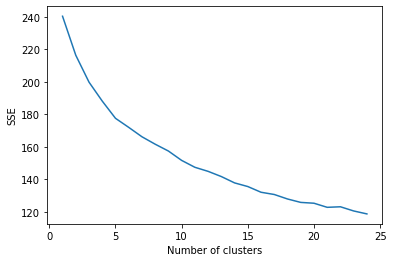

In [38]:
### Here we try to evaluate the number of clusters and their inertia to try and locate the 'elbow'

sse = {}
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(embeddings)
    df["cluster"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [47]:
with pd.option_context('display.max_colwidth', None,
                       'display.max_columns', None,
                       'display.max_rows', None):



    display(df[df['cluster'] ==5].index)

Index(['Acropolis', 'Areopagus', 'Erechtheion', 'Herod Atticus Odeon',
       'Medea and other friends i made in Athens', 'Mount Lycabettus',
       'Panathenaic Stadium', 'Parthenon', 'Philopappos Hill',
       'Philopappos Monument', 'Pnyx', 'Propylaea', 'Temple of Athena Nike',
       'Temple of Hephaestus', 'Theater of Dionysus', 'Tower of the Winds'],
      dtype='object', name='placeInfo/name')

### Above we can see for example that cluster 5 correlates to historical places

In [23]:
df

,text,text_embeddings,cluster
placeInfo/name,,,
#tag ATHENS,Very friendly guide and beautiful visuals - gr...,"[-0.82503694, 0.10236739, 0.4589641, -0.876655...",3
7 Times Athens,The hosting is literally amazing I love how th...,"[-1.7836335, -2.7570653, -2.4061048, -1.428828...",11
A Gem Called Athens,Marleen (our guide) took us on a private walki...,"[-3.4142091, -0.15434985, -2.7100892, 0.209038...",7
A for Athens Cocktail Bar,Amazing bar with phenomenal view of the Acropo...,"[-3.8417385, -0.84662014, -1.1545146, 2.561865...",11
AIOLIS EXPERIENCE,With the company we had some misunderstandings...,"[-1.630549, -1.6792614, 1.4786035, -0.32353225...",17
...,...,...,...
Zappeion Conference & Exhibition Center,Zappeion Hall is the centrepiece of the Nation...,"[-2.5110865, 0.6035067, -2.1319358, -1.8076857...",10
Zen Massage,Had a pregnancy massage here at 6 months pregn...,"[-2.861088, -0.67749894, -1.3750279, -1.626544...",6
babytaxi.gr,"Great service, very comfortable car. Thoroughl...","[-4.9792647, 1.0457178, -0.2917178, 1.9251764,...",4


#### Above we tried to cluster using document embeddings that we trained ourselves, but this didn't seem to be successful, the clusters don't seem to reflect much and this could be for several reasons e.g. the inherent data wasn't rich enough, cluster size fine tuning, or even our trained embeddings(not enough data). 

In [49]:
tokens = 'I want a massage and spa, relaxing experience, get my nails done, with hammam and baths'.split()
new_vector = model.infer_vector(tokens)
sims = model.dv.most_similar([new_vector]) #gives you top 10 document tags and their cosine similarity

In [50]:
sims

[('text_Athens Fish Spa Massage & Hammam', 0.6019613146781921),
 ('text_Salon De Massage', 0.5989214181900024),
 ('text_Hammam Shahrazad', 0.5979065299034119),
 ('text_Hando Massage', 0.5945116877555847),
 ('text_Hammam Baths Athens', 0.5887187719345093),
 ('text_Doctor Fish Athens - Day Spa & Nail Bar', 0.5854371786117554),
 ('text_Ministry of Massage by Athens Massage & Yoga Academy',
  0.5843056440353394),
 ('text_Polis Hammam-Polis Loutron', 0.5822906494140625),
 ('text_Arte Massage Wellness Salon', 0.5689911246299744),
 ('text_Mf Day Spa', 0.5656005144119263)]

In [48]:
 df.loc["Acropolis",'text']

"A revisit first visited in 1969 with family.\nThen again in 90’s and 2004\nA lot of freedom in 1969 able to walk over the Parthenon \n\nNow understand needs protection \n\nAmazing as ever but very crowded!\nViews amazing Far too many visitors on the day took the edge off the experience for us. But popularity is the price of iconic fame for legendary tourist spots like the Acropolis that everybody wants to see, so what can you expect? Still, it was well worth a bit of a hike up to the top of the rock. It’s an impressively large structure close up and also a striking looking sight from down below, viewed from all parts of Athens. A must see if you visit Athens. But will recommend it at a cooler temperature. We were sweating on the top of the hill, even the temperature was around 65F. There are plenty facility staff, who are friendly and helpful. \n\nThe marble stairs are kind of slippery as others  have mentioned, but not too bad for a middle aged couple like us who only moderately acti

### Notes: This works alright - putting in keywords about the vibe, experience etc generally correlates with similar restaurants. Later we want to take for example descriptions/photos of each sample cluster, and let the customer upvote/downvote. This will then be used to find similar restaurants(or hotels/attractions). 


We can also clean this file up to automatically:
1. Narrow down number of entities
2. Automatically cluster based on number of entities(for example number of clusters  = sqrt(total), so if there are 400 restaurants, then 20 clusters.
3. We don't need the clusters to be perfect, just enough that there is some identifiable separation that customers can pick up on.